In [1]:
# flow (invertable) network with custom coupling layer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp


In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.experimental.preprocessing.Normalization()
norm.adapt(data)
normalized_data = norm(data)


In [3]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])


In [4]:
# custom layer class
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


In [5]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)


Epoch 1/300
10/10 - 4s - loss: 2.7049 - val_loss: 2.6272
Epoch 2/300
10/10 - 0s - loss: 2.6042 - val_loss: 2.5847
Epoch 3/300
10/10 - 0s - loss: 2.5593 - val_loss: 2.5312
Epoch 4/300
10/10 - 0s - loss: 2.5183 - val_loss: 2.4985
Epoch 5/300
10/10 - 0s - loss: 2.4762 - val_loss: 2.4599
Epoch 6/300
10/10 - 0s - loss: 2.4423 - val_loss: 2.4228
Epoch 7/300
10/10 - 0s - loss: 2.4069 - val_loss: 2.3856
Epoch 8/300
10/10 - 0s - loss: 2.3661 - val_loss: 2.3430
Epoch 9/300
10/10 - 0s - loss: 2.3341 - val_loss: 2.3134
Epoch 10/300
10/10 - 0s - loss: 2.3117 - val_loss: 2.2867
Epoch 11/300
10/10 - 0s - loss: 2.2892 - val_loss: 2.2681
Epoch 12/300
10/10 - 0s - loss: 2.2577 - val_loss: 2.2533
Epoch 13/300
10/10 - 0s - loss: 2.2350 - val_loss: 2.2210
Epoch 14/300
10/10 - 0s - loss: 2.1992 - val_loss: 2.1835
Epoch 15/300
10/10 - 0s - loss: 2.1877 - val_loss: 2.1486
Epoch 16/300
10/10 - 0s - loss: 2.1579 - val_loss: 2.1633
Epoch 17/300
10/10 - 0s - loss: 2.1442 - val_loss: 2.1202
Epoch 18/300
10/10 - 0s

Epoch 142/300
10/10 - 0s - loss: 1.2260 - val_loss: 1.2701
Epoch 143/300
10/10 - 0s - loss: 1.2632 - val_loss: 1.3378
Epoch 144/300
10/10 - 0s - loss: 1.2630 - val_loss: 1.2466
Epoch 145/300
10/10 - 0s - loss: 1.2346 - val_loss: 1.2479
Epoch 146/300
10/10 - 0s - loss: 1.2457 - val_loss: 1.3135
Epoch 147/300
10/10 - 0s - loss: 1.2761 - val_loss: 1.3480
Epoch 148/300
10/10 - 0s - loss: 1.2508 - val_loss: 1.2539
Epoch 149/300
10/10 - 0s - loss: 1.2355 - val_loss: 1.2525
Epoch 150/300
10/10 - 0s - loss: 1.2164 - val_loss: 1.2463
Epoch 151/300
10/10 - 0s - loss: 1.2284 - val_loss: 1.2427
Epoch 152/300
10/10 - 0s - loss: 1.2031 - val_loss: 1.2273
Epoch 153/300
10/10 - 0s - loss: 1.2216 - val_loss: 1.2227
Epoch 154/300
10/10 - 0s - loss: 1.2143 - val_loss: 1.2450
Epoch 155/300
10/10 - 0s - loss: 1.1983 - val_loss: 1.2256
Epoch 156/300
10/10 - 0s - loss: 1.1965 - val_loss: 1.2719
Epoch 157/300
10/10 - 0s - loss: 1.2315 - val_loss: 1.2725
Epoch 158/300
10/10 - 0s - loss: 1.2201 - val_loss: 1.22

Epoch 281/300
10/10 - 0s - loss: 1.1800 - val_loss: 1.1849
Epoch 282/300
10/10 - 0s - loss: 1.1516 - val_loss: 1.1751
Epoch 283/300
10/10 - 0s - loss: 1.1613 - val_loss: 1.2047
Epoch 284/300
10/10 - 0s - loss: 1.1620 - val_loss: 1.1871
Epoch 285/300
10/10 - 0s - loss: 1.1905 - val_loss: 1.2473
Epoch 286/300
10/10 - 0s - loss: 1.1744 - val_loss: 1.1725
Epoch 287/300
10/10 - 0s - loss: 1.1727 - val_loss: 1.2133
Epoch 288/300
10/10 - 0s - loss: 1.1683 - val_loss: 1.1741
Epoch 289/300
10/10 - 0s - loss: 1.1662 - val_loss: 1.1759
Epoch 290/300
10/10 - 0s - loss: 1.1497 - val_loss: 1.1983
Epoch 291/300
10/10 - 0s - loss: 1.1643 - val_loss: 1.1632
Epoch 292/300
10/10 - 0s - loss: 1.1396 - val_loss: 1.1870
Epoch 293/300
10/10 - 0s - loss: 1.1441 - val_loss: 1.1684
Epoch 294/300
10/10 - 0s - loss: 1.1614 - val_loss: 1.1935
Epoch 295/300
10/10 - 0s - loss: 1.1466 - val_loss: 1.1809
Epoch 296/300
10/10 - 0s - loss: 1.1503 - val_loss: 1.1729
Epoch 297/300
10/10 - 0s - loss: 1.1778 - val_loss: 1.18

(-2.0, 2.0)

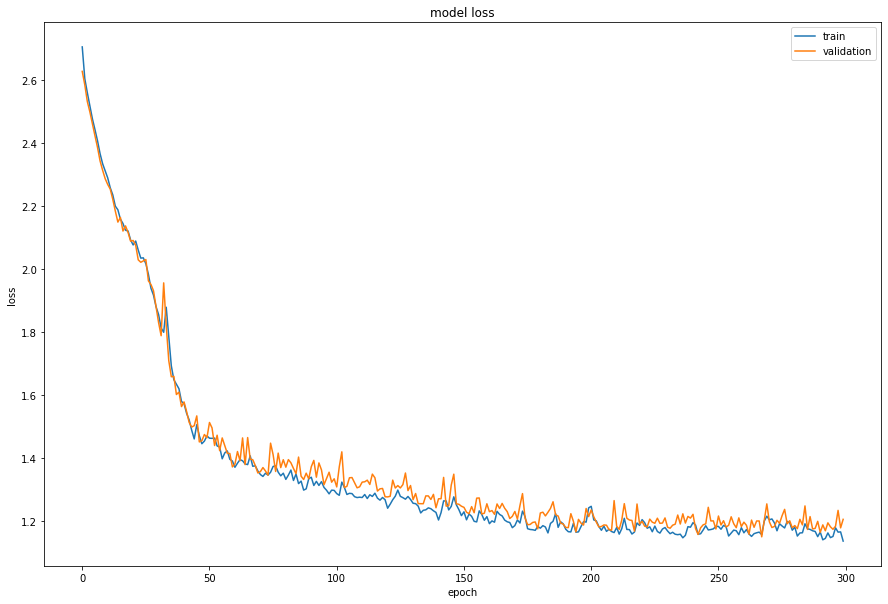

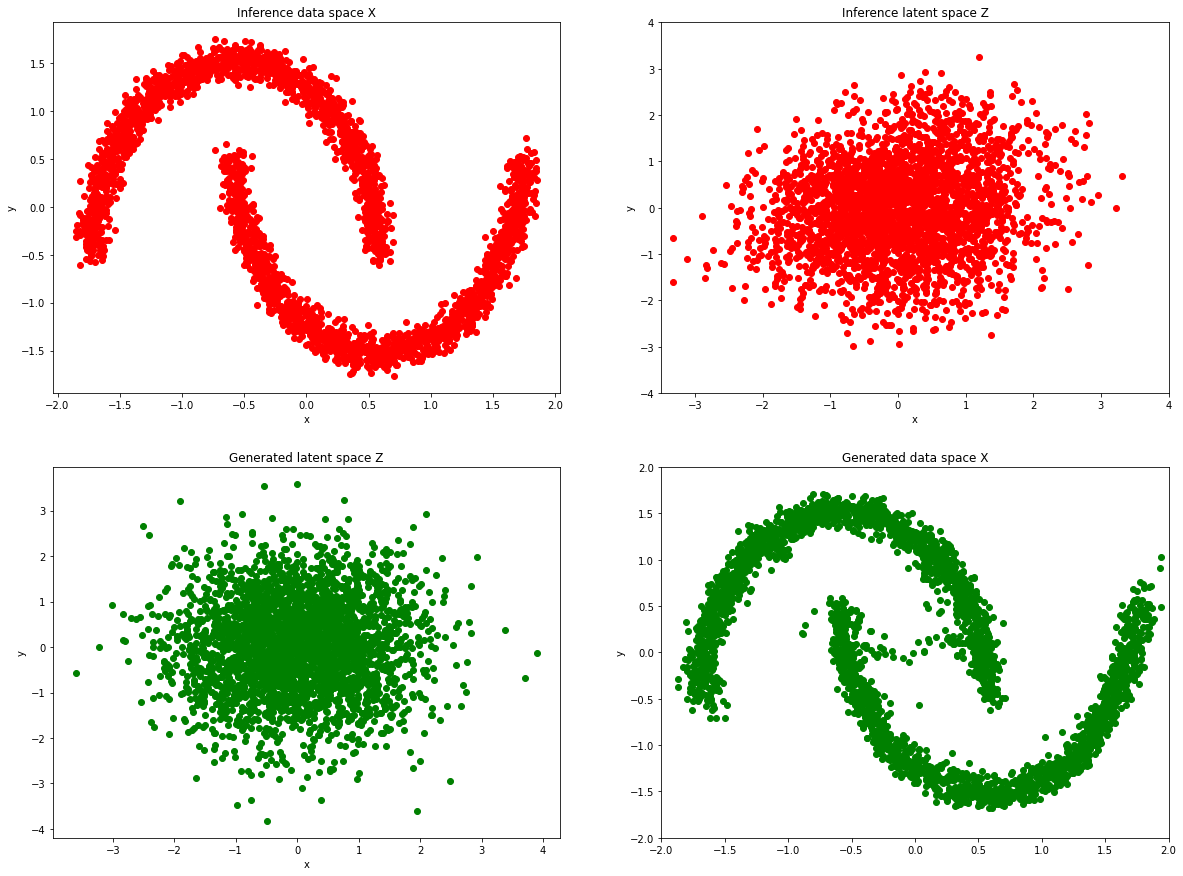

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])
